<a href="https://colab.research.google.com/github/srivardhan-kondu/Explainable-Brain-Tumor-Detection-model-using-Masked-Autoencoders-and-Grad-CAM/blob/main/Explainable_Brain_Tumor_Detection_model_using_Masked_Autoencoders_and_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dataset_path = '/content/drive/MyDrive/brain_tumor_dataset'

In [8]:
img_size = (224, 224)
batch_size = 32


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)


Found 253 files belonging to 2 classes.
Using 203 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [11]:
class_names = train_ds.class_names
print("Classes:", class_names)


Classes: ['no', 'yes']


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

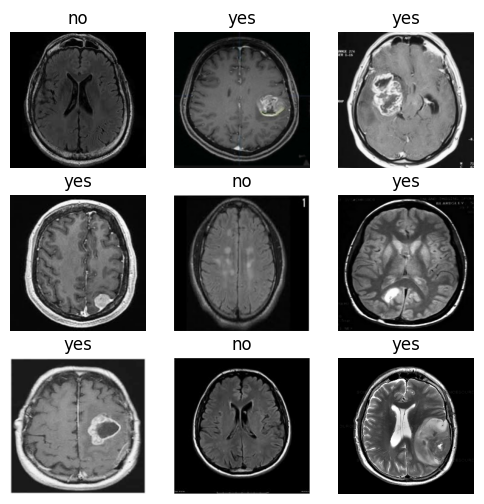

In [13]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [14]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [15]:
import tensorflow as tf

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [17]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)


In [30]:
outputs = layers.Dense(1, activation='sigmoid')(x)  # Add a dense layer for binary classification
model = models.Model(inputs, outputs)

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [32]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [35]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5298 - loss: 0.6904 - val_accuracy: 0.6800 - val_loss: 0.5751
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.6504 - loss: 0.6047 - val_accuracy: 0.7800 - val_loss: 0.5390
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7274 - loss: 0.5654 - val_accuracy: 0.8600 - val_loss: 0.5096
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7411 - loss: 0.5385 - val_accuracy: 0.9000 - val_loss: 0.4854
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7535 - loss: 0.5135 - val_accuracy: 0.9000 - val_loss: 0.4631
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7859 - loss: 0.4585 - val_accuracy: 0.8400 - val_loss: 0.4494
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8330 - loss: 0.4567 - val_accuracy: 0.9000 - val_loss: 0.4331
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8439 - loss: 0.4038 - val_accuracy: 0.8600 - val_loss: 0.4286
Epoch 9/